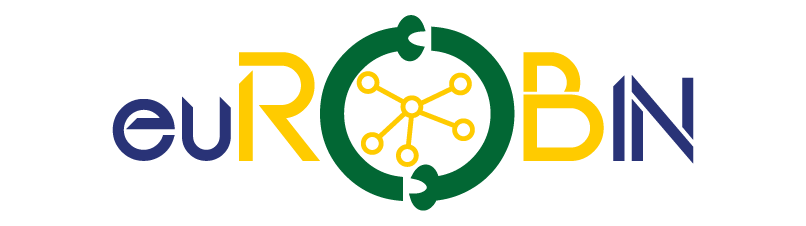

## Robot & Environment

We will work with the TIAGo robot in the IAI Bremen apartment laboratory. Open a new tab in JupyterNotebook, then open a Terminal. Execute the following launchfile in that terminal to launch the environment.
```bash
# load TIAGo
roslaunch cram_projection_demos apartment_tiago.launch

# or load the PR2 
roslaunch cram_projection_demos apartment_pr2.launch
```

Load the CRAM system for our robot demos. Hit CTRL-Enter in the code-blocks to execute them. Wait until the `[*]` symbol turns into a number. Hide the outprint by hitting the blue vertical bar to the left.

In [ ]:
(uiop:run-program 
 "roslaunch cram_projection_demos apartment_tiago.launch &" 
:output t
:error-output t)

(uiop:run-program 
 "roslaunch rvizweb update_config.launch config_file:=${REPO_DIR}/binder/rviz_config.json" 
:output t
:error-output t)

In [ ]:
(asdf:load-system :cram-projection-demos)

In [ ]:
(setf cram-tf:*tf-broadcasting-enabled* t)
(setf cram-tf:*tf-broadcasting-topic* "tf")
(setf cram-tf:*broadcast-environment-from-projection* t)

Initialize the simulation.

In [ ]:
(roslisp-utilities:startup-ros)

The robot appears at 0,0 by default. Position it in the apartment.

In [ ]:
(btr-utils:move-robot '((9 3 0) (0 0 0 1)))

In [ ]:
(urdf-proj:with-projected-robot
 (demos::eurobin-demo))

Source file [eurobin-demo](../../workspace/ros/src/cram/cram_demos/cram_projection_demos/src/eurobin-demo.lisp)

## Plan Execution

With CRAM it is pretty easy to write a sequence of tasks. We will develop a simple plan to fetch a package and unpack it.

* move robot to the door
* open the door
* perceive box
* pick up box
* move robot to delivery location
* place box
* pick up cup from the box
* place cup

In [ ]:
;; Switch to the 'demos' namespace

(in-package :demos)

In [ ]:
;; Reset the simulation

(initialize-eurobin)

In [ ]:
;; Move the robot into the apartment

(btr-utils:move-robot '((9 3 0) (0 0 0 1)))

### Moving torso

In [ ]:
;; Move Torso lower limit

(urdf-proj:with-simulated-robot
  (exe:perform
       (desig:an action
                 (type moving-torso)
                 (joint-angle lower-limit))))

In [ ]:
;; Move Torso to joint-state 0.2

(urdf-proj:with-simulated-robot
  (exe:perform
       (desig:an action
                 (type moving-torso)
                 (joint-angle 0.2))))

In [ ]:
;; Move Torso to upper limit

(urdf-proj:with-simulated-robot
  (exe:perform
       (desig:an action
                 (type moving-torso)
                 (joint-angle upper-limit))))

### Going

In [ ]:
;; Define a pose on the ground for the robot to stand.

(let ((?base-pose 
       (cl-transforms-stamped:make-pose-stamped
        "map" (roslisp:ros-time)
        (cl-tf:make-3d-vector 9.7d0 4.3d0 0.0d0)
        (cl-tf:euler->quaternion :az (* pi 0.25))))) ;; rotate 45 degree
     (urdf-proj:with-simulated-robot
      (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?base-pose)))))))

In [ ]:
(let ((?base-pose 
       (cl-transforms-stamped:make-pose-stamped
        "map" (roslisp:ros-time)
        (cl-tf:make-3d-vector 9.7d0 4.3d0 0.0d0)
        (cl-tf:euler->quaternion :az (* pi 0.5))))) ;; rotate 90 degree
     (urdf-proj:with-simulated-robot
      (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?base-pose)))))))

In [ ]:
(let ((?base-pose 
       (cl-transforms-stamped:make-pose-stamped
        "map" (roslisp:ros-time)
        (cl-tf:make-3d-vector 9.7d0 4.3d0 0.0d0)
        (cl-tf:euler->quaternion :az (* pi 0.75))))) ;; rotate 135 degree
     (urdf-proj:with-simulated-robot
      (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?base-pose)))))))

## Open the door

In [ ]:
;; Open the door a bit

(urdf-proj:with-simulated-robot 
 (exe:perform
  (desig:an action
            (type opening)
            (arm right)
            (distance 0.4)
            (grasps (door-angled))
            (object (desig:an object
                              (type fridge)
                              (urdf-name window4-right)
                              (part-of apartment))))))

In [ ]:
;; Reposition the base to grasp the handle again

(let ((?base-pose 
       (cl-transforms-stamped:make-pose-stamped
        "map" (roslisp:ros-time)
        (cl-tf:make-3d-vector 9.8d0 4.1d0 0.0d0)
        (cl-tf:euler->quaternion :az (* pi 0.75))))) ;; rotate 135 degree
     (urdf-proj:with-simulated-robot
      (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?base-pose)))))))

In [ ]:
;; Open the door a bit

(urdf-proj:with-simulated-robot 
 (exe:perform
  (desig:an action
            (type opening)
            (arm right)
            (distance 1.0)
            (grasps (door-angled))
            (object (desig:an object
                              (type cupboard)
                              (urdf-name window4-right)
                              (part-of apartment))))))

In [ ]:
;; Open the door a lot

(urdf-proj:with-simulated-robot 
 (exe:perform
  (desig:an action
            (type opening)
            (arm right)
            (distance 1.5)
            (grasps (door-angled))
            (object (desig:an object
                              (type cupboard)
                              (urdf-name window4-right)
                              (part-of apartment))))))

## Fetch the package

In [ ]:
;; Spawn the box

(btr-utils:spawn-object :name-of-the-open-box-that-will-be-fetched
                        :open-box :pose '((9.95 5.40 0.8) (0 0 0 1)))

In [ ]:
;; Simulate the world for 1 second

(dotimes (i 10)
    (sleep 0.05)
    (btr:simulate btr:*current-bullet-world* 0.05))

In [ ]:
;; Spawn a pedestal for the box.

(unless (btr:object btr:*current-bullet-world* :package-stand)
    (btr:add-object btr:*current-bullet-world*
                    :cylinder
                    :package-stand
                    '((9.95 5.40 0.35)(0 0 0 1))
                    :size '(0.3 0.3 0.7)
                    :mass 1.0))

In [ ]:
;; Move the box back up onto the pedestal

(btr-utils:spawn-object :name-of-the-open-box-that-will-be-fetched
                        :open-box :pose '((9.95 5.40 0.8) (0 0 0 1)))

In [ ]:
;; Go to the location to pick up the box.

(let ((?picking-up-package-base-pose
      (cl-transforms-stamped:make-pose-stamped
       "map" (roslisp:ros-time)
       (cl-tf:make-3d-vector 9.5d0 4.6d0 0.0d0)
       (cl-tf:euler->quaternion :az (* pi 0.5)))))
     
     (urdf-proj:with-simulated-robot 
         (exe:perform
               (desig:an action
                     (type going)
                     (target (desig:a location
                                      (pose ?picking-up-package-base-pose)))))))

### Handling Failures

Provoke a failure by NOT looking at the package. 

In [ ]:
;; Move the head to look away.

(let ((?look-away-poi
       (cl-tf:make-pose-stamped
        "base_footprint" 0.0
        (cl-tf:make-3d-vector 1.0 0.5 0.5)
        (cl-tf:make-identity-rotation))))
     ;; tilt the head to look to the bottom left.
     (urdf-proj:with-simulated-robot
      (exe:perform
               (desig:an action
                  (type looking)
                  (target (desig:a location
                                   (pose ?look-away-poi)))))))

In [ ]:
;; Perceive package - EXPECTING ERROR: perception-object-not-found

(urdf-proj:with-simulated-robot 
 (exe:perform
  (desig:an action
           (type detecting)
           (object (desig:an object
                             (type open-box))))))

In [ ]:
;; Prepare recovery strategy: look around 

(urdf-proj:with-simulated-robot

(cpl:with-retry-counters ((detect-retries 1))
        ;;;;;;;;;;;;;;;;;;;
        ;; Failure handling
    (cpl:with-failure-handling
        ;; when an object can't be found...
     ((common-fail:perception-object-not-found
       (e) 
       (roslisp:ros-warn (pp-plans pick-up)
                         "Looking-at had a problem: ~a~%Ignoring." e)
       (let ((?door-poi
              (cl-tf:make-pose-stamped "base_footprint" 0.0
                                       (cl-tf:make-3d-vector 1.0 -0.5 0.5)
                                       (cl-tf:make-identity-rotation))))
        ;; tilt the head to look to the bottom right...
          (exe:perform
           (desig:an action
                     (type looking)
                     (target (desig:a location
                                      (pose ?door-poi)))))
          (cpl:do-retry detect-retries
                        (cpl:retry))
          (return))))
        ;; Failure handling
        ;;;;;;;;;;;;;;;;;;;
         
        ;;;;;;;;;;;;;;;;;;;;;;
        ;; Plan to be executed
        ;; perceive on object that looks like an open box
      (exe:perform
       (desig:an action
           (type detecting)
           (object (desig:an object
                             (type open-box))))))))


### Pick & place the package 

In [ ]:
;; Perceive the package and pick it up

(urdf-proj:with-simulated-robot
      ;; perceive package
      (let ((?package-desig (exe:perform
                             (desig:an action
                                       (type detecting)
                                       (object (desig:an object
                                                         (type open-box)))))))
        ;; pick-up the package
        (exe:perform
         (desig:an action
                   (type picking-up)
                   (object ?package-desig)
                   (park-arms nil)))))

In [ ]:
;; Go to target delivery location

(urdf-proj:with-simulated-robot
 (let ((?placing-package-base-pose
           (cl-transforms-stamped:make-pose-stamped
            "map" (roslisp:ros-time)
            (cl-tf:make-3d-vector 15.4d0 2.0d0 0.0d0)
            (cl-tf:euler->quaternion :az (* pi 0.0)))))
      ;; going to placing location
      (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?placing-package-base-pose)))))))

In [ ]:
;; Place the box

(urdf-proj:with-simulated-robot
 (let ((?box-delivery-pose
           (cl-transforms-stamped:make-pose-stamped
            "map" (roslisp:ros-time)
            (cl-tf:make-3d-vector 16.05d0 1.87d0 0.56d0)
            (cl-tf:euler->quaternion :az (* pi 0.0)))))
      ;; place box
      (exe:perform
       (desig:an action
                 (type placing)
                 (target (desig:a location
                                  (pose ?box-delivery-pose)))))))

### Fetching out of the box

In [ ]:
;; Spawn a cup in the box

(btr-utils:spawn-object :jeroen-cup-the-robot-wants
                        :jeroen-cup :pose 
                        '((16.05d0 1.87d0 0.56d0)(0 0 0 1)))

In [ ]:
;; Pick up the cup

(urdf-proj:with-simulated-robot
 (let ((?cup-desig (exe:perform
                       (desig:an action
                                 (type detecting)
                                 (object (desig:an object
                                                   (type jeroen-cup)))))))
     
      (exe:perform
         (desig:an action
                   (type picking-up)
                   (object ?cup-desig)
                   (grasp top)))))

In [ ]:
;; Go to delivery location

(urdf-proj:with-simulated-robot
 (let ((?item-delivery-base-pose
       (cl-transforms-stamped:make-pose-stamped
        "map" (roslisp:ros-time)
        (cl-tf:make-3d-vector 15.6d0 3.0d0 0.0d0)
        (cl-tf:euler->quaternion :az (* pi 0.0)))))
 (exe:perform
  (desig:an action
            (type going)
            (target (desig:a location
                             (pose ?item-delivery-base-pose)))))))

In [ ]:
;; Deliver the cup

(urdf-proj:with-simulated-robot
 (let ((?item-delivery-pose
           (cl-transforms-stamped:make-pose-stamped
            "map" (roslisp:ros-time)
            (cl-tf:make-3d-vector 16.14d0 3.0d0 0.48d0)
            (cl-tf:euler->quaternion :az (* pi 1.0)))))
      (exe:perform
       (desig:an action
                 (type placing)
                 (target (desig:a location
                                  (pose ?item-delivery-pose)))))))

In [ ]:
;; Perform pick and place of cup as a whole

(urdf-proj:with-simulated-robot
(let ((?placing-package-base-pose
           (cl-transforms-stamped:make-pose-stamped
            "map" (roslisp:ros-time)
            (cl-tf:make-3d-vector 15.4d0 2.0d0 0.0d0)
            (cl-tf:euler->quaternion :az (* pi 0.0))))
      (?item-delivery-base-pose
           (cl-transforms-stamped:make-pose-stamped
            "map" (roslisp:ros-time)
            (cl-tf:make-3d-vector 15.5d0 3.0d0 0.0d0)
            (cl-tf:euler->quaternion :az (* pi 0.0))))
         (?item-delivery-pose
           (cl-transforms-stamped:make-pose-stamped
            "map" (roslisp:ros-time)
            (cl-tf:make-3d-vector 16.2d0 3.0d0 0.48d0)
            (cl-tf:euler->quaternion :az (* pi 0.0)))))
     ;; Going
     (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?placing-package-base-pose)))))
     
     (btr-utils:spawn-object :jeroen-cup-the-robot-wants 
                             :jeroen-cup :pose '((16.05d0 1.87d0 0.56d0)(0 0 0 1)))

      (let ((?package-desig (exe:perform
                             (desig:an action
                                       (type detecting)
                                       (object (desig:an object
                                                         (type jeroen-cup)))))))
        ;; pick-up the package
        (exe:perform
         (desig:an action
                   (type picking-up)
                   (object ?package-desig)
                   (grasp top))))

      (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?item-delivery-base-pose)))))

      (exe:perform
       (desig:an action
                 (type placing)
                 (target (desig:a location
                                  (pose ?item-delivery-pose)))))))

In [ ]:
(btr-utils:kill-all-objects)

In [ ]:
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------

In [ ]:
;; This function positions the arms, moves the torso up and moves the robot to the initial position

(defun park-robot (&optional (?nav-pose
                              (cl-transforms-stamped:make-pose-stamped
                               cram-tf:*fixed-frame*
                               0.0
                               (cl-transforms:make-identity-vector)
                               (cl-transforms:make-identity-rotation))))
  (cpl:with-failure-handling
      ((cpl:plan-failure (e)
         (declare (ignore e))
         (return)))
    (cpl:par
      (exe:perform
       (desig:an action
                 (type positioning-arm)
                 (left-configuration park)
                 (right-configuration park)))
      (exe:perform
       (desig:an action
                 (type moving-torso)
                 (joint-angle upper-limit)))
      (exe:perform
       (desig:an action
                 (type going)
                 (target (desig:a location
                                  (pose ?nav-pose)))))
      (exe:perform (desig:an action (type opening-gripper) (gripper (left right))))
      (exe:perform (desig:an action (type looking) (direction forward))))))

# Utils


In [ ]:
;; Reset the debug window

(btr-utils:reset-debug-window)

In [ ]:
 (let ((?pose
           (cl-transforms-stamped:make-pose-stamped
            "map" (roslisp:ros-time)
            (cl-tf:make-3d-vector 16.14d0 3.0d0 0.48d0)
            (cl-tf:euler->quaternion :az (* pi 1.0)))))
      
      ;; Visualize a pose
      (btr:add-vis-axis-object ?pose))

In [ ]:
;; Park Arms

(urdf-proj:with-simulated-robot
 (exe:perform
       (desig:an action
                 (type positioning-arm)
                 (left-configuration park)
                 (right-configuration park))))